In [1]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv2D, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers, Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import locale
from matplotlib import image as mpimg
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16


# optimizador de la red por medio de Bayessian Optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Abrimos nuestros dataset para prepararlo
# ./drive/MyDrive/deep-learning-rogelio/train_data.csv
df_train = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/train_data.csv', sep=';', decimal='.')
print(df_train.shape)

df_test = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/test_data.csv', sep=';', decimal='.')
print(df_test.shape)

# Vamos a abrir las imágenes
trainImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/trainImagesX.npy")
print(trainImagesX.shape)

# Abrimos las imagenes de test
testImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/testImagesX.npy")
print(testImagesX.shape)


(750, 22)
(250, 22)
(750, 224, 224, 3)
(250, 224, 224, 3)


In [4]:
x_train_images = trainImagesX / 255
x_test_images = testImagesX / 255

In [5]:
# Hacemos el split de train y validation para las imágenes y los atributos
# Lo hacemos con el dataframe completo, aún no separamos los valores

split = train_test_split(df_train, x_train_images, test_size=0.1, random_state=42)
(trainAttrX, valAttrX, trainImagesX, valImagesX) = split

In [6]:
# Separamos x_train, y_train y convertimos a numpy
x_train = trainAttrX.drop(['Price'], axis=1).values
y_train = trainAttrX['Price'].values

x_val = valAttrX.drop(['Price'], axis=1).values
y_val = valAttrX['Price'].values

# Separamos x_test, y_test y convertimos a numpy
x_test = df_test.drop(['Price'], axis=1).values
y_test = df_test['Price'].values

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [12]:
print()

### Primer prueba
En esta primer prueba vamos a congelar todas las capas del modelo VGG16, añadimos un par de capas al final y entrenamos el modelo

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import metrics 

# Load the ResNet50V2 model without the top layers and set it to non-trainable
# base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top to the model for regression
x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear')(x)

# Compile the model
model = models.Model(base_model.input, x)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', 
              metrics=[
                  metrics.MeanAbsoluteError(), 
                  metrics.MeanSquaredError(), 
                  metrics.RootMeanSquaredError()])

# Define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(x=trainImagesX, y=y_train, batch_size=128, epochs=50, validation_data=(valImagesX, y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate the model on the test set
test_pred = model.predict(x_test_images)
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


Epoch 1/50
6/6 [==============================] - 12s 2s/step - loss: 7030.8237 - mean_absolute_error: 61.9949 - mean_squared_error: 7030.8237 - root_mean_squared_error: 83.8500 - val_loss: 4688.5698 - val_mean_absolute_error: 52.6607 - val_mean_squared_error: 4688.5698 - val_root_mean_squared_error: 68.4731 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 3s 463ms/step - loss: 6015.5093 - mean_absolute_error: 53.0906 - mean_squared_error: 6015.5093 - root_mean_squared_error: 77.5597 - val_loss: 3784.6013 - val_mean_absolute_error: 43.4157 - val_mean_squared_error: 3784.6013 - val_root_mean_squared_error: 61.5191 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 3s 467ms/step - loss: 5085.3042 - mean_absolute_error: 44.7051 - mean_squared_error: 5085.3042 - root_mean_squared_error: 71.3113 - val_loss: 3058.1887 - val_mean_absolute_error: 35.9346 - val_mean_squared_error: 3058.1887 - val_root_mean_squared_error: 55.3009 - lr: 1.0000e-04
Epoch 4/50
6/6 

[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 63.57%, std: 70.86%


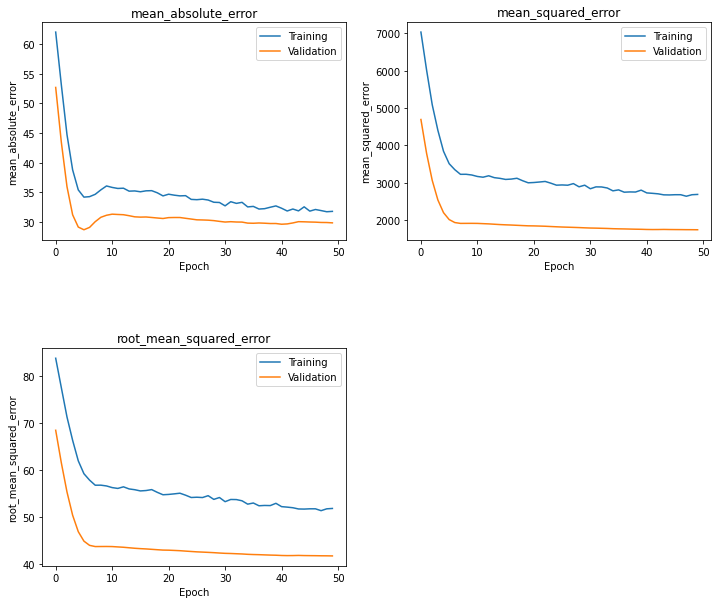

In [14]:
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

#### No está mal, sin embargo, vamos a probar entrenando mas capas de la red y añadiendo las 2 ultimas a VGG16

### Transfer learning modificando mas capas

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import metrics 

# Load the ResNet50V2 model without the top layers and set it to non-trainable
# base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model_2 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Add a custom top to the model for regression
"""
x = layers.Flatten()(base_model_2.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear')(x)
"""

# add a global spatial average pooling layer
x = base_model_2.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# Compile the model
# model2 = models.Model(base_model_2.input, x)
# this is the model we will train
model2 = Model(inputs=base_model_2.input, outputs=predictions)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_2.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model2.layers[:16]:
   layer.trainable = False
for layer in model2.layers[16:]:
   layer.trainable = True

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [16]:


#model2.compile(optimizer=SGD(lr=0.00001, momentum=0.99), loss='mse',metrics=['mse','mae'])


model2.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', 
              metrics=[
                  metrics.MeanAbsoluteError(), 
                  metrics.MeanSquaredError(), 
                  metrics.RootMeanSquaredError()])

# Define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model2.fit(x=trainImagesX, y=y_train, batch_size=128, steps_per_epoch=10, epochs=50, validation_data=(valImagesX, y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate the model on the test set
test_pred = model2.predict(x_test_images)
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)

Epoch 1/50
10/10 [==============================] - 10s 662ms/step - loss: 6603.9141 - mean_absolute_error: 56.5225 - mean_squared_error: 6603.9141 - root_mean_squared_error: 81.2645 - val_loss: 2725.7820 - val_mean_absolute_error: 32.7183 - val_mean_squared_error: 2725.7820 - val_root_mean_squared_error: 52.2090 - lr: 1.0000e-04
Epoch 2/50
10/10 [==============================] - 6s 561ms/step - loss: 3304.5513 - mean_absolute_error: 37.9927 - mean_squared_error: 3304.5513 - root_mean_squared_error: 57.4852 - val_loss: 2589.5408 - val_mean_absolute_error: 43.9644 - val_mean_squared_error: 2589.5408 - val_root_mean_squared_error: 50.8875 - lr: 1.0000e-04
Epoch 3/50
10/10 [==============================] - 6s 561ms/step - loss: 3180.7493 - mean_absolute_error: 37.2736 - mean_squared_error: 3180.7493 - root_mean_squared_error: 56.3981 - val_loss: 1850.0961 - val_mean_absolute_error: 30.4538 - val_mean_squared_error: 1850.0961 - val_root_mean_squared_error: 43.0127 - lr: 1.0000e-04
Epoch 

[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 73.73%, std: 80.37%


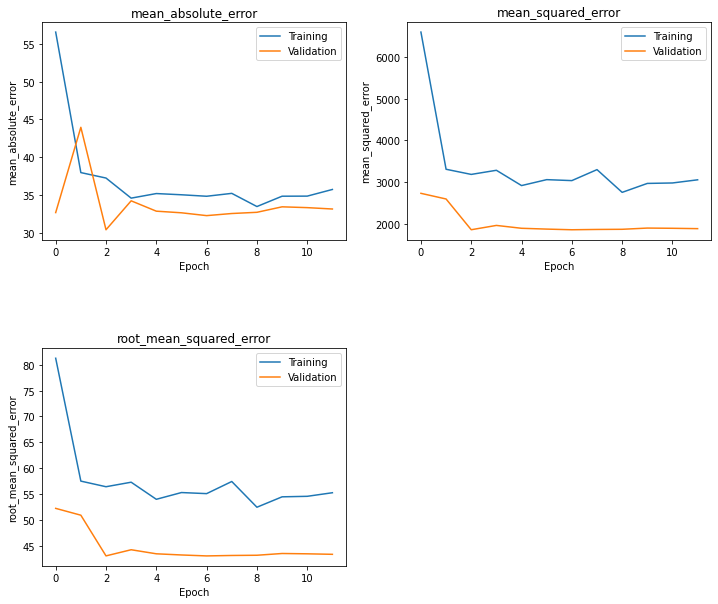

In [17]:
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

In [18]:
print(np.sqrt(np.mean((test_pred - y_test)**2)))

41.93489369394706


In [ ]:
# Guardamos el modelo 
#model2.save('transfer_l_v2')

In [ ]:
#!cp -r transfer_l_v2 /content/drive/My\ Drive/deep-learning-rogelio/transfer_l_v2

In [19]:
model2.save('transfer_l_v2.h5')
!cp -r transfer_l_v2.h5 /content/drive/My\ Drive/deep-learning-rogelio/transfer_l_v2.h5

## Se ve un poco mas prometedor el modelo, ya que se observan fluctuaciones, lo ideal es buscar buenos parámetros y ver si modificando capas especificas podemos mejorar el modelo